In [1]:
!pip install -qU langgraph langchain-groq langchain-community

In [2]:
import os
from sqlalchemy import create_engine
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph
from pydantic import BaseModel
from typing import Optional

from google.colab import userdata, drive
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Database setup
DB_PATH = "/content/drive/MyDrive/product-database/products.db"
DATABASE_URL = f"sqlite:///{DB_PATH}"
os.makedirs(os.path.dirname(DB_PATH), exist_ok=True)
engine = create_engine(DATABASE_URL, echo=True)
db = SQLDatabase.from_uri(DATABASE_URL)

In [4]:
# LLM & Chain setup
llm = ChatGroq(
    model_name="llama3-70b-8192",
    groq_api_key=GROQ_API_KEY,
    temperature=0
)

chain = create_sql_query_chain(llm, db)

In [5]:
class State(BaseModel):
    user_input: str
    raw_query: Optional[str] = None
    cleaned_query: Optional[str] = None
    query_result: Optional[str] = None
    final_response: Optional[str] = None

In [6]:
def generate_query(state: State):
    """Generate an SQL query, clean it, and fetch results from the database."""

    state.raw_query = chain.invoke({"question": state.user_input})

    return state

In [7]:
def clean_query(state: State):
    """Clean the SQL query by removing formatting and fixing common issues"""

    clean_prompt = [
        {
            "role": "system",
            "content": "\n".join([
                "You are an AI chatbot for an e-commerce platform.",
                "Your role is to clean and format SQL queries to be safely executed in an SQLite database.",
                "Ensure the query is free from unnecessary markdown formatting such as ``` and ```sql.",
                "Remove any single or double quotes around column names, ensuring proper SQLite syntax.",
                "Preserve the query structure and ensure it remains valid and executable.",
                "Never modify table names, column names, or logical conditions; only clean the format.",
                "Return only the cleaned SQL query without any additional explanation or comments."
            ])
        },
        {
            "role": "user",
            "content": f"Clean this SQL query for safe execution in SQLite: {state.raw_query}"
        }
    ]

    state.cleaned_query = llm.invoke(clean_prompt).content

    return state

In [8]:
def execute_query(state: State):
    """Execute the provided SQL query and return the result."""

    try:
        state.query_result = db.run(state.cleaned_query)
    except Exception as e:
        state.query_result = f"Error executing query: {str(e)}"

    return state

In [9]:
def generate_response(state: State):
    """Generate a user-friendly response based on the query result."""

    response_prompt = [
        {
            "role": "system",
            "content": "\n".join([
                "You are an AI chatbot for an e-commerce platform.",
                "Your role is to transform database query results into clear, user-friendly responses.",
                "Ensure that users receive relevant and easy-to-understand information based on their requests.",
                "Help users find the best products that meet their needs by providing structured and informative responses.",
                "If multiple relevant products are found, summarize them concisely while maintaining clarity.",
                "Never generate any introduction or conclusion, Just answer the user directly."
            ])
        },
        {
            "role": "user",
            "content": f"Convert this results into a user-friendly response: {state}"
        }
    ]

    state.final_response = llm.invoke(response_prompt)

    return state

In [10]:
workflow = StateGraph(State)

workflow.add_node("generate_sql", generate_query)
workflow.add_node("clean_sql", clean_query)
workflow.add_node("execute_query", execute_query)
workflow.add_node("generate_response", generate_response)


workflow.set_entry_point("generate_sql")
workflow.add_edge("generate_sql", "clean_sql")
workflow.add_edge("clean_sql", "execute_query")
workflow.add_edge("execute_query", "generate_response")

graph = workflow.compile()

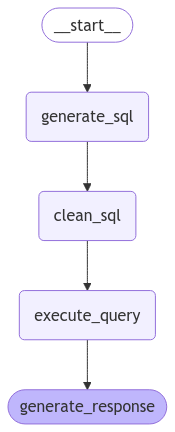

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [12]:
def start_chatbot():
    print("Hello! I am your product assistant. (Type 'exit' to quit)\n")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            break

        state = graph.invoke(State(user_input=user_input))

        bot_response = state["final_response"].content
        print("Bot:", bot_response, "\n")

In [13]:
start_chatbot()

Hello! I am your product assistant. (Type 'exit' to quit)

You: What's the cheapest product, and what is its description?
Bot: The cheapest product is the Mechanical Pencil Set, priced at $19.99. It's a premium mechanical pencil set that comes with extra refills. 

You: How many electronic products does the company sell, and what are their average rating?
Bot: The company sells 5 electronic products, and their average rating is 4.54 out of 5. 

You: What products cost less than $50? just give the names, prices, and ratings.
Bot: Here are 5 products that cost less than $50:

* Smart Fitness Tracker: $49.99, rated 4.3
* Organic Cotton T-Shirt: $24.99, rated 4.7
* Yoga Mat: $29.99, rated 4.4
* LED Desk Lamp: $39.99, rated 4.2
* Wireless Mouse: $25.99, rated 4.3 

You: What are the top rated brands? and what are their average prices?
Bot: Here are the top 5 rated brands along with their average prices:

1. VisionTech - $299.99
2. PureAir - $159.99
3. ChefPro - $89.99
4. TimeTech - $199.99


In [14]:
# Question Samples:

# What's the cheapest product, and what is its description?
# How many products does the company sell, and how many in the stock?
# How many electronic products does the company sell, and what are their average rating?
# What products cost less than $50? just give the names, prices, and ratings.
# What categories does the company have? and what is the stock of each?
# What are the top rated brands? and what are their average prices?
# Show me all wireless products, with their description, and rating.
# I usually use wireless devices, can u recommend me some?